In [63]:
import numpy as np
import torch
from torch import nn
from skorch import NeuralNetRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [64]:
class LinearLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = nn.Parameter(torch.randn(output_size, input_size))  # Random initialization of weights
        self.bias = nn.Parameter(torch.randn(output_size))  # Random initialization of bias

    def forward(self, x):
        #Forward pass of the linear layer. x: Input data, shape (batch_size, input_size)
        self.input = x
        self.output = torch.matmul(x, self.weights.t()) + self.bias
        return self.output

class RidgeRegression(nn.Module):
    def __init__(self, input_dim, output_dim, alpha=1):
        super(RidgeRegression, self).__init__()
        self.linear = LinearLayer(input_dim, output_dim)
        self.alpha = alpha
    
    def forward(self, x):
        return self.linear.forward(x)
    
    def l2_regularization(self):
        l2_norm = torch.norm(self.linear.weights)
        return self.alpha * l2_norm

In [65]:
np.random.seed(1)

#Testing with a straight line
X = 1 * np.random.rand(50, 1)
y = 0.5 + 3 * X + np.random.randn(50, 1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
alpha = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]


In [30]:
model = NeuralNetRegressor(
    module=RidgeRegression,
    module__input_dim=input_dim,
    module__output_dim=output_dim,
    module__alpha=alpha,
    criterion=nn.MSELoss,
    optimizer=torch.optim.SGD,
    optimizer__lr=0.01,
    max_epochs=5000,
    device='cuda' if torch.cuda.is_available() else 'cpu', 
)

In [31]:
model.fit(X_train, y_train)

# Predicting on test data
y_pred = model.predict(X_test)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       16.2264       14.2870  0.0046
      2       15.4999       13.6150  0.0069
      3       14.8084       12.9760  0.0038
      4       14.1502       12.3685  0.0056
      5       13.5237       11.7909  0.0049
      6       12.9274       11.2417  0.0061
      7       12.3599       10.7195  0.0047
      8       11.8196       10.2231  0.0057
      9       11.3054        9.7512  0.0042
     10       10.8160        9.3025  0.0061
     11       10.3502        8.8760  0.0048
     12        9.9068        8.4706  0.0072
     13        9.4847        8.0852  0.0067
     14        9.0830        7.7188  0.0073
     15        8.7006        7.3706  0.0096
     16        8.3366        7.0397  0.0064
     17        7.9902        6.7251  0.0077
     18        7.6605        6.4261  0.0089
     19        7.3466        6.1420  0.0060
     20        7.0478        5.8720  0.0039
     21        6.7634        5.6

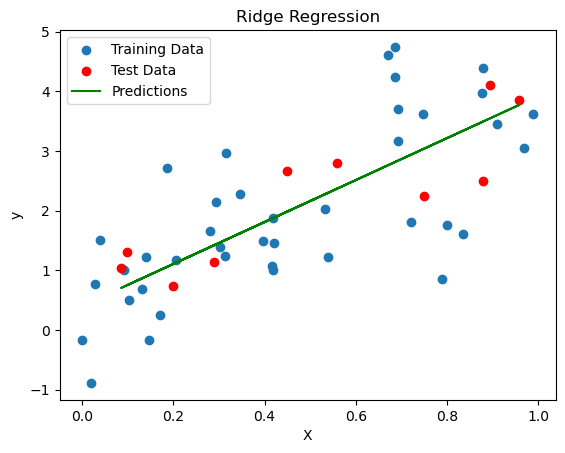

In [36]:
# Plotting
plt.scatter(X_train, y_train, label='Training Data')
plt.scatter(X_test, y_test, color='red', label='Test Data')
plt.plot(X_test, y_pred, color='green', label='Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Ridge Regression')
plt.legend()
plt.show()

In [52]:
class LinearLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = nn.Parameter(torch.randn(output_size, input_size))  # Random initialization of weights
        self.bias = nn.Parameter(torch.randn(output_size))  # Random initialization of bias

    def forward(self, x):
        # Forward pass of the linear layer. x: Input data, shape (batch_size, input_size)
        self.input = x
        self.output = torch.matmul(x, self.weights.t()) + self.bias
        return self.output

class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 32], output_dim=1):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(LinearLayer(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class RidgeRegressionv2(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, alpha=0.01):
        super(RidgeRegressionv2, self).__init__()
        self.mlp = MLP(input_dim, hidden_dims, output_dim)
        self.alpha = alpha
        self.loss_function = nn.MSELoss()

    def forward(self, x):
        return self.mlp(x)

    def l2_regularization(self):
        l2_norm = 0
        for param in self.mlp.parameters():
            l2_norm += torch.norm(param)
        return self.alpha * l2_norm


In [85]:
modelv2 = NeuralNetRegressor(
    module=RidgeRegressionv2,
    module__input_dim=input_dim,
    module__hidden_dims=[128,64],
    module__output_dim=output_dim,
    module__alpha=alpha,
    optimizer=torch.optim.SGD,
    optimizer__lr=0.001,
    max_epochs=1000,
    device='cuda' if torch.cuda.is_available() else 'cpu', 
)

In [93]:
X = 1 * np.random.rand(200, 1)
y = 0.5 + 3 * X + np.random.randn(200, 1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
alpha = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]

In [87]:
modelv2.fit(X_train, y_train)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       29.2938      142.3001  0.0318
      2      128.4737      581.5688  0.0299
      3      573.0652     1967.0518  0.0317
      4     1862.6160     1587.8093  0.0389
      5     1568.9329        2.0667  0.0329
      6        3.3214        1.6251  0.0301


      7        2.8326        1.3225  0.0367
      8        2.4762        1.1090  0.0227
      9        2.2073        0.9548  0.0364
     10        1.9994        0.8417  0.0239
     11        1.8362        0.7582  0.0256
     12        1.7065        0.6963  0.0314
     13        1.6028        0.6505  0.0252
     14        1.5197        0.6171  0.0276
     15        1.4528        0.5929  0.0244
     16        1.3989        0.5760  0.0282
     17        1.3554        0.5644  0.0209
     18        1.3203        0.5570  0.0226
     19        1.2920        0.5528  0.0234
     20        1.2691        0.5509  0.0252
     21        1.2506        0.5507  0.0277
     22        1.2357        0.5518  0.0237
     23        1.2237        0.5538  0.0332
     24        1.2139        0.5564  0.0246
     25        1.2060        0.5594  0.0313
     26        1.1996        0.5627  0.0376
     27        1.1945        0.5660  0.0594
     28        1.1903        0.5693  0.0208
     29        1.1868        0.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RidgeRegressionv2(
    (mlp): MLP(
      (model): Sequential(
        (0): LinearLayer()
        (1): ReLU()
        (2): LinearLayer()
        (3): ReLU()
        (4): Linear(in_features=64, out_features=1, bias=True)
      )
    )
    (loss_function): MSELoss()
  ),
)

In [94]:
# Predicting on test data
y_pred = modelv2.predict(X_test)

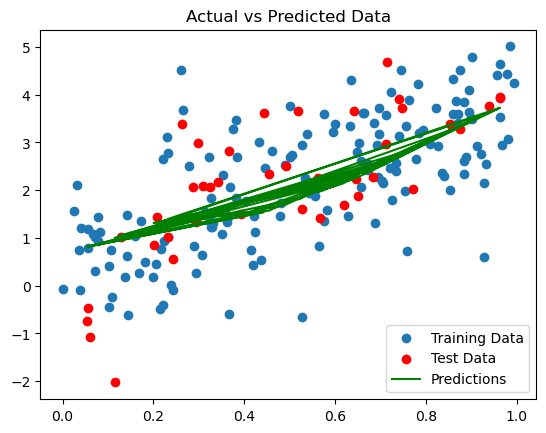

In [95]:
plt.scatter(X_train, y_train, label='Training Data')
plt.scatter(X_test, y_test, color='red', label='Test Data')

plt.title('Actual vs Predicted Data')
plt.plot(X_test, y_pred, color='green', label='Predictions')

plt.legend()
plt.show()